## Packages

In [1]:
!pip install pdfplumber PyPDF2
! pip install transformers
import datetime
!pip install sentencepiece accelerate
from transformers import T5Tokenizer, T5ForConditionalGeneration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.9 MB/s eta 0:00:00


In [2]:
import requests
from io import BytesIO
import os
import pdfplumber
import re
from urllib.parse import unquote
from tqdm import tqdm
import io
from PyPDF2 import PdfReader
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
palette = ['#ffbe0b',"#fb5607","#ff006e","#8338ec"]
sns.set_theme(style="white",font_scale = 1.2)
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Extract and Process PDF Files

This code extracts and processes PDF files.

In [18]:
def create_df_from_txt_file(txt_file_path):
    def extract_year(url):
        pattern = r'(19[0-9]{2}|20[0-9]{2})'
        matches = re.findall(pattern, url)
        return matches[0] if matches else None
    with open(txt_file_path, 'r') as file:
        urls = file.read().splitlines()
    data = []
    for url in urls:
        year = extract_year(url)
        data.append({'URL': url, 'Year': year})

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    return df

In [20]:
def pdf_to_text(file_path):
    try:
        with open(file_path, 'rb') as file:
            reader = PdfReader(file)
            text = ''
            for i in range(len(reader.pages)):
                text += reader.pages[i].extract_text()
        return re.sub(r'\s+', ' ', text).strip()
    except Exception as e:
        return ''
def extract_sentences_from_pdf(url):
    sentences = []
    # Extract text using the pdf_to_text function
    text = pdf_to_text(url)
    # split to senteces by: . ! ? \n
    sentences.extend(re.split(r'[.!?]\s+|\n', text))
    return sentences

def process_df(df):
    # Use tqdm to create a progress bar for the PDF processing
    tqdm.pandas(desc="Processing PDF files")
    # Apply the extract_sentences_from_pdf function to each URL in the 'url' column
    df['sentences'] = df['URL'].progress_apply(extract_sentences_from_pdf)
    return df

In [21]:
def clean_partial_processed_data(file_path: str) -> pd.DataFrame:

    """
    Processes a CSV file containing company data and category classifications.
    """

    # Load the csv file into a DataFrame
    data = pd.read_csv(file_path)

    # Identify rows with unique URLs that start with 'https://'
    company_indicator_rows = data['URL']

    # Extract company data (URL, Company Name, and Year)
    company_data = data[company_indicator_rows][['URL', 'Year']]

    # Extract category data from rows below the company rows
    category_data_rows = data.iloc[company_data.index[-1]+1:]
    category_data_cleaned = category_data_rows.dropna(subset=['category_1', 'category_2', 'category_3', 'category_4', 'category_5'])

    # Reset indices for proper alignment
    company_data = company_data.reset_index(drop=True)
    category_data_cleaned = category_data_cleaned.reset_index(drop=True)

    # Merge the two dataframes
    final_data = pd.concat([company_data, category_data_cleaned[['category_1', 'category_2', 'category_3', 'category_4', 'category_5']]], axis=1)
    final_data.drop(['URL'],axis=1,inplace=True)
    final_data.dropna(inplace=True)
    final_data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'Year']] = final_data[['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'Year']].astype(int)
    return final_data


In [22]:
txt_file_path = '/content/drive/MyDrive/company.txt'
df = create_df_from_txt_file(txt_file_path)
df

,URL,Year
0,/content/drive/MyDrive/data/2022_released_CGN_...,2022
1,/content/drive/MyDrive/data/2023_released_CGN_...,2023
2,/content/drive/MyDrive/data/2024_released_CGN_...,2024


In [23]:
# create senteces of each df
full_processed_df = process_df(df)
full_processed_df

Processing PDF files: 100%|██████████| 3/3 [00:14<00:00,  4.70s/it]


,URL,Year,sentences
0,/content/drive/MyDrive/data/2022_released_CGN_...,2022,"[Environmental, Social and Governance (Incorpo..."
1,/content/drive/MyDrive/data/2023_released_CGN_...,2023,[(Incorporated in B ermuda with limit ed liabi...
2,/content/drive/MyDrive/data/2024_released_CGN_...,2024,[(Incorporated in B ermuda with limit ed liabi...


In [24]:
# Save to CSV
full_processed_df.to_csv("/content/drive/MyDrive/extracted_text_sustainability_reports.csv", index=False)

##2.  Distributions

Present the distribution of years, companies, and senteces

In [11]:
# load the df
df = pd.read_csv("/content/drive/MyDrive/extracted_text_sustainability_reports.csv")

# Convert Year column to int
df['Year'] = df['Year'].astype(int)
df = df[['Year','sentences']]

# split to senteces
def split_into_sentences(text):
    return [sentence.strip() for sentence in text.split('\',')]

df['sentences'] = df['sentences'].apply(split_into_sentences)
# Remove the leading ' and trailing " characters from each sentence in the list
df['sentences'] = [
    [sentence.strip("'").strip('"') for sentence in sentence_list]
    for sentence_list in df['sentences']
]

# count number of senteces in each PDF
df['sentence_count'] = df['sentences'].apply(len)
df

,Year,sentences,sentence_count
0,2024,[['(Incorporated in B ermuda with limit ed lia...,1073
1,2023,[['(Incorporated in B ermuda with limit ed lia...,904
2,2022,"[['Environmental, Social and Governance (Incor...",688


In [12]:
# Calculate statistics
statistics = {
    'Number of Sentences': {
        'Average': np.mean(df['sentence_count']),
        'Median': np.median(df['sentence_count']),
        'Standard Deviation': np.std(df['sentence_count']),
        'Max': int(np.max(df['sentence_count'])),
        'Min': int(np.min(df['sentence_count']))
    },
    'Year': {
        'Mode': df['Year'].mode().values[0],
        'Median': np.nan,
        'Standard Deviation': np.std(df['Year']),
       'Max': int(np.max(df['Year'])),
        'Min': int(np.min(df['Year']))
    }
}

# Create a DataFrame to display the statistics
statistics_df = pd.DataFrame(statistics)

# Display the table
statistics_df

,Number of Sentences,Year
Average,888.333333,NaN
Median,904.000000,NaN
Standard Deviation,157.565507,0.816497
Max,1073.000000,2024.000000
Min,688.000000,2022.000000
Mode,NaN,2022.000000


## 3. Apply the model

In [13]:
df = pd.read_csv("/content/drive/MyDrive/extracted_text_sustainability_reports.csv")
df['Year'] = df['Year'].astype(int)  # Convert 'Year' column to integer

def split_into_sentences(text):
    return [sentence.strip() for sentence in text.split('\',')]

df['sentences'] = df['sentences'].apply(split_into_sentences)
# Remove the leading ' and trailing " characters from each sentence in the list
df['sentences'] = [
    [sentence.strip("'").strip('"') for sentence in sentence_list]
    for sentence_list in df['sentences']
]
df

,URL,Year,sentences
0,http://www.cgnne.com/encgnneh/c100585/2024-04/...,2024,[['(Incorporated in B ermuda with limit ed lia...
1,http://www.cgnne.com/encgnneh/c100585/2023-04/...,2023,[['(Incorporated in B ermuda with limit ed lia...
2,http://www.cgnne.com/encgnneh/c100585/2022-05/...,2022,"[['Environmental, Social and Governance (Incor..."


Import model

In [14]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Create prompt and define df to store the model

In [15]:
def detect_category(sentence):
    input_text = "Act as an expert ESG analyst.\n" \
                 "You will be provided a sentence related to a company's environmental, social, and governance (ESG) practices and performance. Your task is to classify each sentence into one of the following five categories:\n" \
                 "[1] Quantitative Evidence: The sentence contains specific numerical or percentage data demonstrating actions the company has already taken to improve its ESG measures. The sentence is primarily in past or present tense.\n" \
                 "[2] Action Evidence: The sentence contains concrete evidence, but no numbers/percentages, showing actions the company has already taken to improve ESG. The sentence is primarily in past or present tense.\n" \
                 "[3] Suggestive Evidence: The sentence suggests, but does not directly state, that the company has already taken actions to improve ESG. It does not contain concrete evidence. The sentence is primarily in past or present tense.\n" \
                 "[4] Future Plan: The sentence discusses the company's plans or intentions to take future ESG actions, but does not provide any evidence of current or past actions. The sentence is primarily in future tense.\n" \
                 "[5] Other: The sentence does not fit any of the above categories.\n"\
                 "For each sentence in the text file, return a number 1-5 indicating which category it belongs to.\n"\
                 f"Sentece: {sentence}"
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids
    outputs = model.generate(input_ids)
    output_text = tokenizer.decode(outputs[0])
    # Extract number from the output text using regex
    extracted_number = re.search(r'\d+', output_text)
    if extracted_number:
        return int(extracted_number.group())
    return None

processed_df = df.copy().reset_index()

# Initialize category columns in processed_df
for i in range(1, 6):
    processed_df[f'category_{i}'] = 0
processed_df

# Create df to store the results
processed_df = processed_df[['URL','Year','sentences','category_1','category_2','category_3','category_4','category_5']]
processed_df.head()

,URL,Year,sentences,category_1,category_2,category_3,category_4,category_5
0,http://www.cgnne.com/encgnneh/c100585/2024-04/...,2024,[['(Incorporated in B ermuda with limit ed lia...,0,0,0,0,0
1,http://www.cgnne.com/encgnneh/c100585/2023-04/...,2023,[['(Incorporated in B ermuda with limit ed lia...,0,0,0,0,0
2,http://www.cgnne.com/encgnneh/c100585/2022-05/...,2022,"[['Environmental, Social and Governance (Incor...",0,0,0,0,0


In [17]:
# Run the model on each sentence

for index, row in enumerate(processed_df.iterrows()):
    # Get the current timestamp
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Display message with timestamp for the PDF being processed
    print(f"\r[{current_time}] Processing PDF {index + 5}", end='', flush=True)

    _, row_data = row
    sentences_categories = []
    category_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

    for sentence_num, sentence in enumerate(row_data['sentences']):
        # Display message with timestamp for the sentence being processed
        print(f"\r[{current_time}] Processing sentence {sentence_num + 1} in PDF {index + 5}", end='', flush=True)

        if len(sentence) < 5:
            continue

        category = detect_category(sentence)

        if category is None:
            print(f'\r[{current_time}] Skipped sentence due to error', end='', flush=True)
            continue

        sentences_categories.append(category)
        category_counts[category] += 1

    for i in range(1, 6):
        processed_df.at[index, f'category_{i}'] = category_counts[i]

    # Save the processed DataFrame to a CSV file every 5 iterations
    if (index + 1) % 3 == 0:
        partial_output_csv = f"/content/drive/MyDrive/Yehuda-Model-dfs/partial_processed_data_{index + 451}.csv"
        processed_df.to_csv(partial_output_csv, index=False)
        print(f"\nSaved partially processed DataFrame to {partial_output_csv}")


# Print the processed DataFrame
print("\nProcessed DataFrame:")
print(processed_df)

[2024-10-19 02:14:44] Processing sentence 1 in PDF 5

Token indices sequence length is longer than the specified maximum sequence length for this model (842 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[2024-10-19 04:39:56] Processing sentence 688 in PDF 7
Saved partially processed DataFrame to /content/drive/MyDrive/Yehuda-Model-dfs/partial_processed_data_453.csv

Processed DataFrame:
                                                 URL  Year  \
0  http://www.cgnne.com/encgnneh/c100585/2024-04/...  2024   
1  http://www.cgnne.com/encgnneh/c100585/2023-04/...  2023   
2  http://www.cgnne.com/encgnneh/c100585/2022-05/...  2022   

                                           sentences  category_1  category_2  \
0  [['(Incorporated in B ermuda with limit ed lia...         104         187   
1  [['(Incorporated in B ermuda with limit ed lia...          82         139   
2  [['Environmental, Social and Governance (Incor...          55         107   

   category_3  category_4  category_5  
0         323         113         292  
1         235         127         274  
2         175         107         211  


In [18]:
processed_df

,URL,Year,sentences,category_1,category_2,category_3,category_4,category_5
0,http://www.cgnne.com/encgnneh/c100585/2024-04/...,2024,[['(Incorporated in B ermuda with limit ed lia...,104,187,323,113,292
1,http://www.cgnne.com/encgnneh/c100585/2023-04/...,2023,[['(Incorporated in B ermuda with limit ed lia...,82,139,235,127,274
2,http://www.cgnne.com/encgnneh/c100585/2022-05/...,2022,"[['Environmental, Social and Governance (Incor...",55,107,175,107,211


## 4. Results & Stataitics
Comparisons a company in different years

In [19]:
df = pd.read_csv("/content/drive/MyDrive/Yehuda-Model-dfs/partial_processed_data_453.csv")
df = df[['Year', 'category_1', 'category_2','category_3', 'category_4', 'category_5']]
df.head()

,Year,category_1,category_2,category_3,category_4,category_5
0,2024,104,187,323,113,292
1,2023,82,139,235,127,274
2,2022,55,107,175,107,211


### Mean Precentage of each Category (1-4)

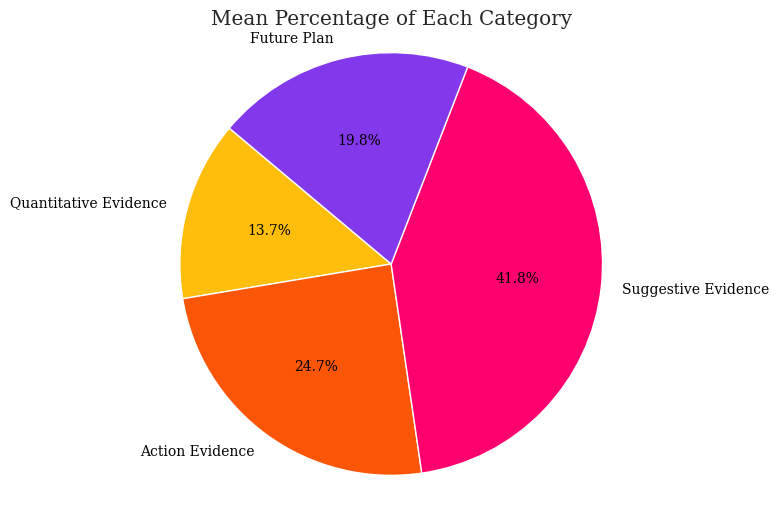

In [20]:
categories = ['category_1', 'category_2', 'category_3', 'category_4']
category_labels = [
    "Quantitative Evidence",
    "Action Evidence",
    "Suggestive Evidence",
    "Future Plan",
]

# Calculate the mean percentage for each category
mean_percentages = []
for category in categories:
    mean_percentage = df[category].mean()
    mean_percentages.append(mean_percentage)

# Create a pie plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    mean_percentages,
    labels=category_labels,
    autopct='%.1f%%',
    startangle=140,
    colors=palette,
    textprops=dict(color="black")
)

# Add category labels to the center of each wedge
for text, autotext in zip(texts, autotexts):
    text.set(size=10)
    autotext.set(size=10)

# Set title and aspect ratio
plt.title('Mean Percentage of Each Category')
plt.axis('equal')

# Show the plot
plt.show()

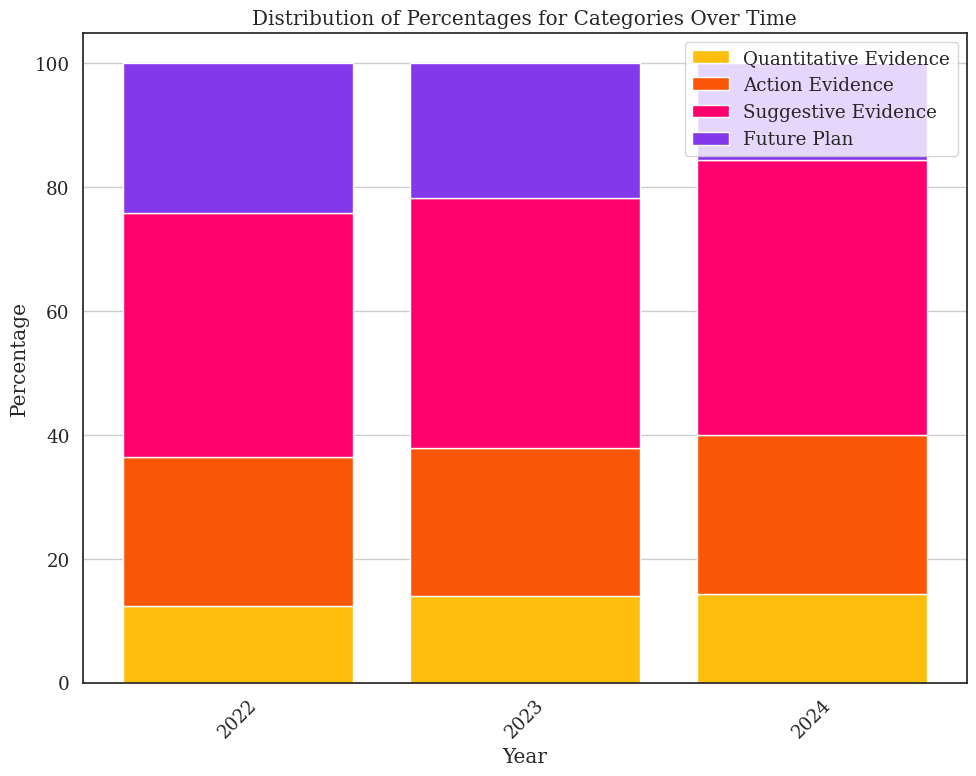

In [35]:
# Assuming your DataFrame is named 'df'
category_labels = [
    "Quantitative Evidence",
    "Action Evidence",
    "Suggestive Evidence",
    "Future Plan"
]

years = df['Year']

# Generate random data for demonstration (replace this with your data)
data = df[['category_1', 'category_2', 'category_3', 'category_4']].values.transpose()

# Calculate the sum of percentages for each year
yearly_totals = np.sum(data, axis=0)

# Normalize the data to get percentages
normalized_data = data / yearly_totals * 100

fig, ax = plt.subplots(figsize=(10, 8))

# Create a stacked bar plot for each category
bottom = np.zeros(len(years))
for idx, category_label in enumerate(category_labels):
    bars = ax.bar(years, normalized_data[idx], label=category_label, bottom=bottom, color=palette[idx])
    bottom += normalized_data[idx]

ax.set_title("Distribution of Percentages for Categories Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.legend()
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax.grid(axis="y")

plt.tight_layout()
plt.show()